In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from hydranerv.utils import utils, disp

## 1. Cluster peaks

In [228]:
def get_clusters(nmovie, fpath='./cb_locs/ctr/'):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    inc = 0
    # Read txt files
    filelist = sorted(os.listdir(fpath))
    clusters_all = []

    for imovie in range(1, nmovie+1):

        # Extract peak locations
        locs = []
        for filename in filelist:
            if filename.endswith(".txt") and filename.startswith(str(imovie)):
                locs.append(pd.read_csv(fpath + filename, header=None).values[0])

        # Cluster the peaks
        clusters = []
        for peaks in locs:
            clusters.extend(utils.cluster_peaks(peaks, 50, realign=True))

        # Plot the cluster spikes
        disp.add_spike_trains(ax, clusters, 2, lw=1, color=utils.randomcolor(), inc=inc)
        clusters_all.extend(clusters)
        inc += len(clusters)

    plt.xlim(0, 300)
    plt.ylim(0, inc)
    plt.show()
    return clusters_all

### Control

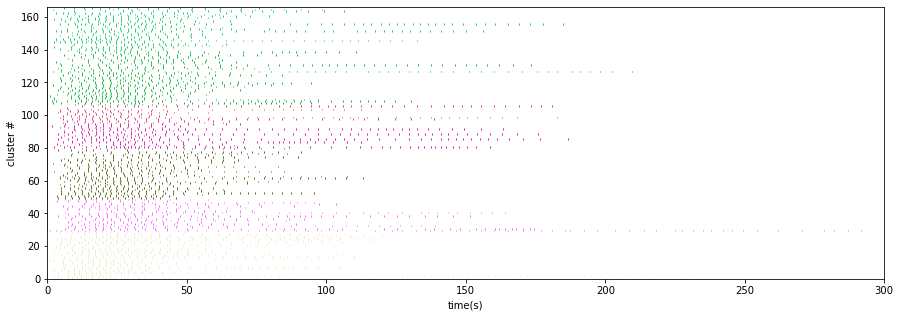

In [232]:
clusters_ctr_all = get_clusters(7, './cb_locs/ctr/')

### Low

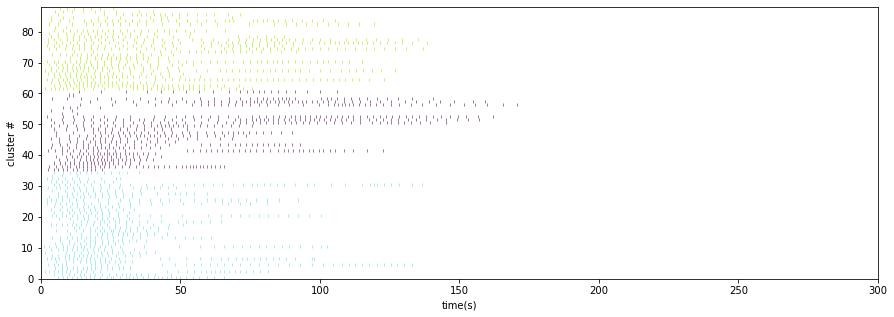

In [238]:
clusters_lo_all = get_clusters(3, './cb_locs/low/')

### High

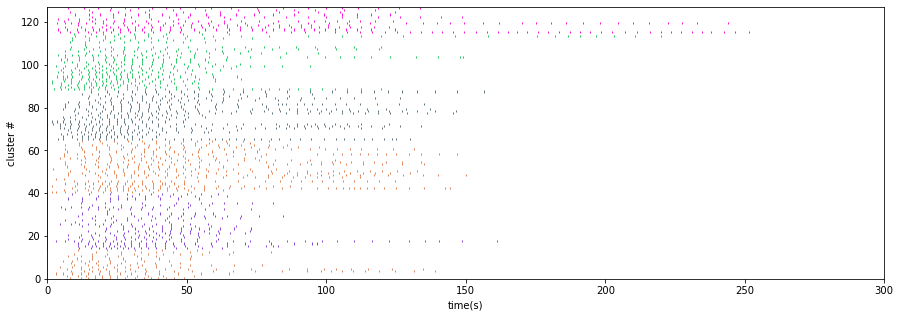

In [239]:
clusters_hi_all = get_clusters(6, './cb_locs/high/')

## 2. Statistical analysis

### Average pulses number

In [240]:
def avg_pulse_number(clusters):
    n = 0
    for cluster in clusters:
        n += len(cluster)
    return n / len(clusters)

In [241]:
print('ctr: ', avg_pulse_number(clusters_ctr_all))
print('low: ', avg_pulse_number(clusters_lo_all))
print('high: ', avg_pulse_number(clusters_hi_all))

ctr:  21.8855421686747
low:  24.363636363636363
high:  18.708661417322833


### Average duration

In [242]:
def avg_duration(clusters, fps=2):
    d = 0
    for cluster in clusters:
        d += cluster[-1] - cluster[0]
    return d / len(clusters) / fps

In [243]:
print('ctr: ', avg_duration(clusters_ctr_all))
print('low: ', avg_duration(clusters_lo_all))
print('high: ', avg_duration(clusters_hi_all))

ctr:  78.86144578313252
low:  68.17045454545455
high:  87.14173228346456


### Average firing frequency

In [244]:
def avg_f(clusters, fps=2):
    f = 0
    for cluster in clusters:
        f += len(cluster) / (cluster[-1] - cluster[0]) / fps
    return f / len(clusters)

In [245]:
print('ctr: ', avg_f(clusters_ctr_all))
print('low: ', avg_f(clusters_lo_all))
print('high: ', avg_f(clusters_hi_all))

ctr:  0.07219513327654867
low:  0.09356950679057846
high:  0.05585285280977792


### Inter-spike intervals (boxplot)

In [246]:
def get_isi(clusters, fps=2):
    isi = []
    for cluster in clusters:
        isi.append([(cluster[j+1] - cluster[j]) / fps for j in range(len(cluster)-1)])
    df = pd.DataFrame(isi)
    isi_mat = np.array(df.where(pd.notnull(df), None))
    return isi_mat.T

In [154]:
isi_ctr_all = get_isi(clusters_ctr_all)
isi_lo_all = get_isi(clusters_lo_all)
isi_hi_all = get_isi(clusters_hi_all)

In [155]:
isi_ctr_all

array([[2.0, 2.5, 4.0, ..., 9.5, 2.0, 6.0],
       [1.5, 2.5, 3.5, ..., 11.0, 11.5, 3.5],
       [1.5, 3.0, 2.0, ..., 6.5, 5.5, 3.5],
       ...,
       [None, 1.5, None, ..., None, None, None],
       [None, 2.0, None, ..., None, None, None],
       [None, 6.0, None, ..., None, None, None]], dtype=object)

In [202]:
def plot_isi_stat(isi):
    plt.figure(figsize=(20,7))
    plt.plot(isi, alpha=.1, zorder=0)
    bplot = plt.boxplot(utils.transpose_2d_list(isi.T.tolist()), 
                positions=range(len(isi)), 
                patch_artist=True,
                zorder=1,
                )
    plt.setp(bplot["fliers"], markeredgecolor='gray')
    for patch in bplot['boxes']:
        patch.set_facecolor('lightblue')
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .7))
    plt.xlim(0, 80)
    plt.xticks(np.arange(0, len(isi)+1, 5), np.arange(0, len(isi)+1, 5))
    plt.xlabel('index of interval')
    plt.ylabel('ISI (s)')
    plt.show()

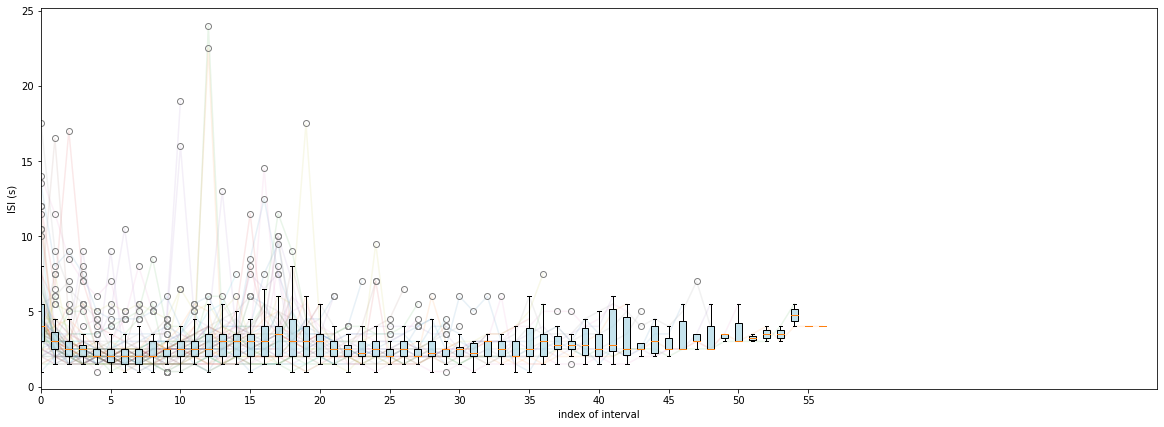

In [203]:
plot_isi_stat(isi_lo_all)

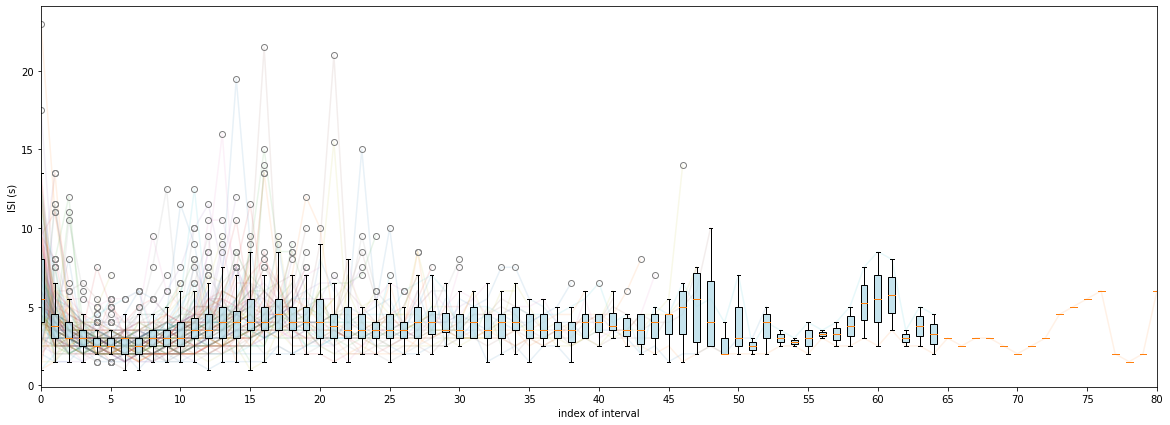

In [204]:
plot_isi_stat(isi_ctr_all)

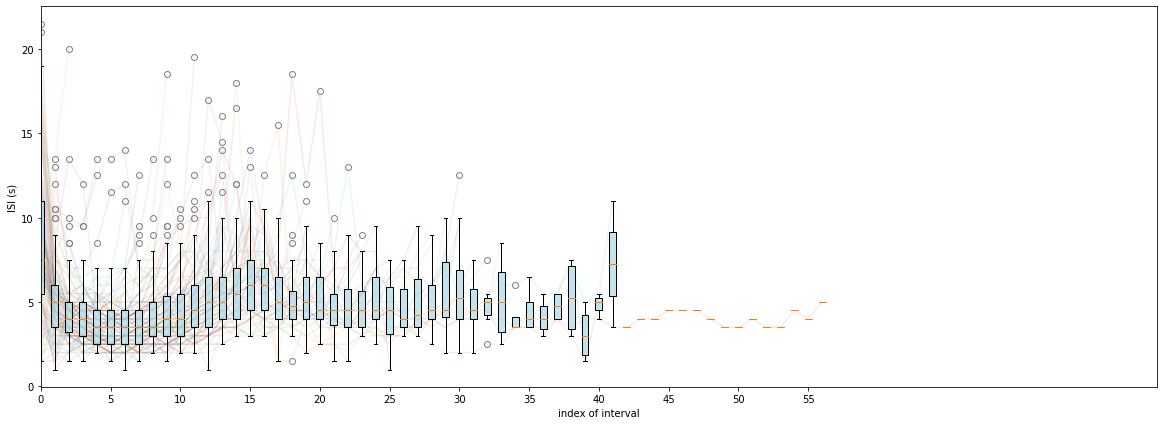

In [205]:
plot_isi_stat(isi_hi_all)

### ISI (error bands)

In [197]:
isi_mean_ctr_all = np.nanmean(np.array(isi_ctr_all, dtype=float), axis=1)
isi_mean_lo_all = np.nanmean(np.array(isi_lo_all, dtype=float), axis=1)
isi_mean_hi_all = np.nanmean(np.array(isi_hi_all, dtype=float), axis=1)

In [198]:
isi_min_ctr_all = np.nanmin(np.array(isi_ctr_all, dtype=float), axis=1)
isi_min_lo_all = np.nanmin(np.array(isi_lo_all, dtype=float), axis=1)
isi_min_hi_all = np.nanmin(np.array(isi_hi_all, dtype=float), axis=1)

In [199]:
isi_max_ctr_all = np.nanmax(np.array(isi_ctr_all, dtype=float), axis=1)
isi_max_lo_all = np.nanmax(np.array(isi_lo_all, dtype=float), axis=1)
isi_max_hi_all = np.nanmax(np.array(isi_hi_all, dtype=float), axis=1)

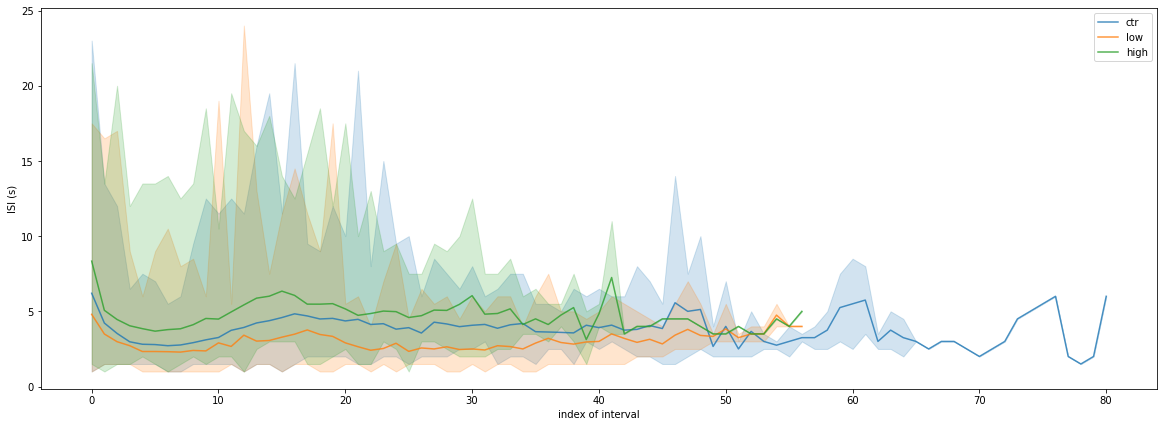

In [248]:
plt.figure(figsize=(20,7))
alpha_mean = .8
alpha_err = .2
colorlist = ['#1f77b4', '#ff7f0e', '#2ca02c']
plt.plot(isi_mean_ctr_all, label='ctr', alpha=alpha_mean, color=colorlist[0])
plt.plot(isi_mean_lo_all, label='low', alpha=alpha_mean, color=colorlist[1])
plt.plot(isi_mean_hi_all, label='high', alpha=alpha_mean, color=colorlist[2])
plt.fill_between(range(len(isi_mean_ctr_all)), isi_min_ctr_all, isi_max_ctr_all, alpha=alpha_err, color=colorlist[0])
plt.fill_between(range(len(isi_mean_lo_all)), isi_min_lo_all, isi_max_lo_all, alpha=alpha_err, color=colorlist[1])
plt.fill_between(range(len(isi_mean_hi_all)), isi_min_hi_all, isi_max_hi_all, alpha=alpha_err, color=colorlist[2])
plt.legend()
plt.xlabel('index of interval')
plt.ylabel('ISI (s)')
plt.show()

## 3. Single videos analysis

### Control